In [10]:
import gymnasium as gym
import ale_py
import torch
import numpy as np
import random
from collections import deque

from a2c import *

Setting up variables

In [11]:
RANDOM_STATE = 42
torch.seed = RANDOM_STATE
torch.manual_seed(torch.seed)
np.random.seed(torch.seed)
random.seed(torch.seed)

ENV_NAME = 'ALE/Bowling-ram-v5'

Testing environnement

In [12]:
env = gym.make(ENV_NAME)

state, _ = env.reset()
print(f"Initial state: \n{state}")
print(f"Observation space: \n{env.observation_space}")
print(f"Action space: {env.action_space}")

a = env.action_space.sample()
event = env.step(a)
print('Output from applying action {} on environment:\nstate:'.format(a) \
      + '{}\nreward: {}\ndone: {}\ntruncated: {}\ninfo: {}'.format(*event))

Initial state: 
[ 71 255   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   8  15   0   0   0 170   0
   1   0   0   0   1  12 184 247   0   0   6  16  19  13  22  16  10  25
  19  13   7   7   5   5   3   3   3   1   1   1   1   0   0   0   0   0
   0   0   0   0   0 136 216 132  38  88   0   0   1 255   0 255 128 255
   0   0   0   0   0   0   0   2   2   0   8   8   0  34  34   0 136 136
   0  34  34   0   8   8   0   2   2   0   0   0   0   0   0   0   0   0
  66 243]
Observation space: 
Box(0, 255, (128,), uint8)
Action space: Discrete(6)
Output from applying action 2 on environment:
state:[ 75 255   0   1   0  16   4   4   4   4   4   4 255   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   8  15   0   2   0 170   0
   1   0   0   0   1  12 184 247   0   0   0  16  19  13  22  16  10  25
  19  13   7   7   5   5   3   3   3   1   1   1   1   0   0   0   0   0
   0   0   0   0   0 136 216 132  38  88   0  

Defining A2CBatch

In [13]:
class A2CBatch(A2C):
    def __init__(self, env):
        super().__init__(env)
        # Overrides the loss function for the actor. Since we are trying batch processing, we need to sum up the losses
        self.actorLossFun = lambda probs, advantage: - \
            1 * torch.sum(torch.log(probs) * advantage)

    # Trains the agent            
    def train(self, epochs=200, gamma=0.99, memory=500, batch=200):
        # Stores the info from the training process
        info = {}
        # Stores the total reward or scores per epoch
        scores = []
        # The replay buffer for Q-learning with experience replay
        replay = deque(maxlen=memory)
        for e in range(epochs):
            # Resets the environment per epoch
            state_, _ = self.env.reset()
            # A flag to check if an episode has ended
            done = False
            # Stores the score per episode
            score = 0
            # Maximum number of allowed moves per episode
            maxMoves = 200
            # Stores the information per move in an episode
            iterations = []            
            # Continue the episode until it ends or the maximum number of episodes has expired
            while not done and maxMoves > 0:
                # Decrement the number of allowed moves
                maxMoves -= 1
                # Calculate the probs. for the actions for a given state
                policy = self.actor(torch.from_numpy(
                    state_).float())
                # Choose an action based on their probs.
                action = np.random.choice(
                    self.numActionSpace, p=policy.detach().numpy())
                # Executes an action to the environment
                nextState_, reward, done, truncated, _ = self.env.step(action)
                # Updates the rewards for the episode
                score += reward
                # Calculates the value of the current state
                value = self.critic(torch.from_numpy(state_).float())
                # Calculate the value of the next state
                nextValue = torch.Tensor([0.0]) if done else self.critic(
                    torch.from_numpy(nextState_).float())
                
                # Add the experience to the buffer
                replay.append((state_, reward, nextValue.item()))
                # Add the episode step info
                iterations.append(
                    (state_, action, reward, nextValue.item() - value.item())) 
                # Assign next state as current state
                state_ = nextState_

            # After each episode update the actor model
            # Policy Loss
            iterations_ = np.asarray(iterations, dtype=object)  
            # Calculate the advantage
            advantage = torch.Tensor(list(iterations_[:, 2])).float() + torch.pow(gamma, torch.arange(
                len(iterations_)).flip(dims=(0, )).float()) * torch.Tensor(list(iterations_[:, 3])).float()

            # Store the state info as a batch of states
            stateBatch = torch.stack([torch.from_numpy(s).float()
                                      for s in iterations_[:, 0]])
            # Store the action info as a batch of actions    
            actionBatch = torch.Tensor(list(iterations_[:, 1]))
            # Feed the state batch to the actor model to calculate the probs of actions for each state in the batch
            policy = self.actor(stateBatch)
            # Gets the probs of actions actually performed for each state
            probs = policy.gather(
                dim=1, index=actionBatch.long().unsqueeze(dim=1)).squeeze()

            # Policy Loss
            actorLoss = self.actorLossFun(probs, advantage)
            #Backpropagate policy
            self.actorOptim.zero_grad()
            actorLoss.backward()
            self.actorOptim.step()

            # Update the value function if the size of the replay buffer is larger than the specified batch size
            if (len(replay) > batch):
                # Select a set of random indices to be chosen from the replay buffer 
                indices = np.random.choice(len(replay), size=batch)
                # Extract the experiences from the replay buffer
                replay_ = np.asarray(replay, dtype=object)[indices, :]  
                # Create a state batch with the excted experiences
                stateBatch = torch.stack([torch.from_numpy(s).float()
                                          for s in replay_[:, 0]])
                # Calculate the value for the extracted states                                        
                value = self.critic(stateBatch)                                                
                
                # Value Loss
                criticLoss = self.criticLossFun(
                    value, torch.Tensor(list(replay_[
                        :, 1] + gamma * replay_[:, 2])).float())
                                
                #Backpropagate value
                self.criticOptim.zero_grad()
                criticLoss.backward()
                self.criticOptim.step()            
                
            # Store the total score for the episode
            scores.append(score)

            # Print the progress
            if e % np.round(epochs/10) == 0:
                print('episode: {:d}, score: {:.2f}'.format(e, scores[e]))
            info[e] = scores[e]

        return info

episode: 0, score: 0.00


c:\Cours\UiS\RL\Project\reinforcement-learning\venv\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


episode: 200, score: 0.00
episode: 400, score: 0.00
episode: 600, score: 0.00
episode: 800, score: 0.00
episode: 1000, score: 0.00
episode: 1200, score: 0.00
episode: 1400, score: 0.00
episode: 1600, score: 0.00
episode: 1800, score: 0.00


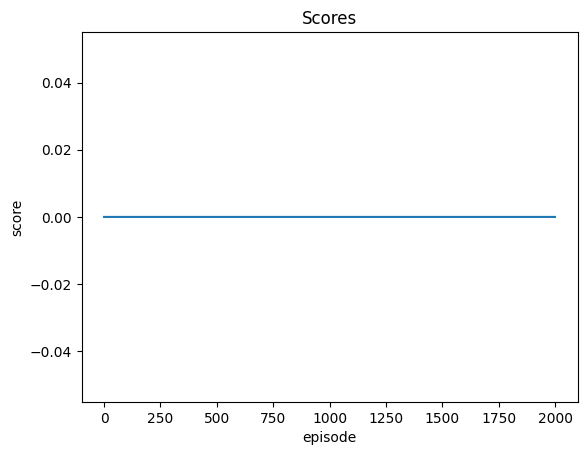

Error: Invalid render mode `None`. Supported modes: `human`, `rgb_array`.

In [14]:
# Instantiate the agent class.
agent = A2CBatch(env)
# Train the agent
info = agent.train(epochs=2000)
# Convert to an numpy array with epochs at axis=0 and scores at axis=1
info_ = np.array(list(info.items()))
# Plot the scores
agent.plot(info_)
# Run a test
agent.test()